In [1]:
from scipy.stats import multivariate_normal
import numpy as np


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def compute_function_labels(slope: float, intercept: float, noise_std_dev: float, data: np.ndarray) -> np.ndarray:
    """
    Compute target values given function parameters and data.
    
    Args:
        slope: slope of the function (theta_1)
        intercept: intercept of the function (theta_0)
        data: input feature values (x)
        noise_std_dev: standard deviation of noise distribution (sigma)
        
    Returns:
        target values, either true or corrupted with noise
    """
    n_samples = len(data)
    if noise_std_dev == 0: # Real function
        return slope * data + intercept
    else: # Noise corrupted
        return slope * data + intercept + np.random.normal(0, noise_std_dev, n_samples)

In [3]:
# Set random seed to ensure reproducibility
seed = 42
np.random.seed(seed)

# Generate true values and noise corrupted targets
n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5

# Generate dataset
features = np.random.uniform(lower_bound, upper_bound, n_datapoints)
labels = compute_function_labels(slope, intercept, 0., features)
noise_corrupted_labels = compute_function_labels(slope, intercept, noise_std_dev, features)

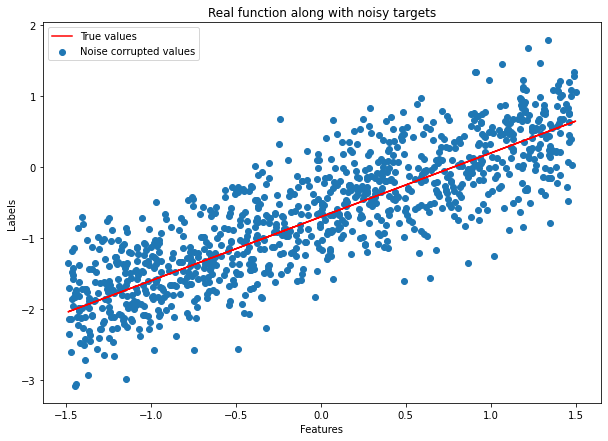

In [4]:
# Plot the dataset
plt.figure(figsize=(10,7))
plt.plot(features, labels, color='r', label="True values")
plt.scatter(features, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();

In [5]:
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np

class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """
    
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to m_0 (prior_mean) and S_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to m_N in formulas
        self.post_cov = self.prior_cov # corresponds to S_N in formulas
        
    def update_posterior(self, features: np.ndarray, targets: np.ndarray):
        """
        Update the posterior distribution given new features and targets
        
        Args:
            features: numpy array of features
            targets: numpy array of targets
        """
        
        print('features:', features.shape)
        print('targets:', targets.shape)
        
        # Reshape targets to allow correct matrix multiplication
        # Input shape is (N,) but we need (N, 1)
        targets = targets[:, np.newaxis]
        print('targets:', targets.shape)
        
        # Compute the design matrix, shape (N, 2)
        design_matrix = self.compute_design_matrix(features)
        print('design_matrix:', design_matrix.shape)

        # Update the covariance matrix, shape (2, 2)
        design_matrix_dot_product = design_matrix.T.dot(design_matrix)
        inv_prior_cov = np.linalg.inv(self.prior_cov)
        self.post_cov = np.linalg.inv(inv_prior_cov +  self.noise_precision * design_matrix_dot_product)
        print('post_cov:', self.post_cov.shape)
        
        # Update the mean, shape (2, 1)
        print('noise_precision:', self.noise_precision)
        print('design_matrix:', design_matrix.shape)
        print('targets:', targets.shape)
        print('prior_mean:', self.prior_mean.shape)
        print('post_cov:', self.post_cov.shape)

        self.post_mean = self.post_cov.dot(  inv_prior_cov.dot(self.prior_mean) + self.noise_precision * design_matrix.T.dot(targets))
        print('post_mean:', self.post_mean.shape)

        print('post_mean.flatten():', self.post_mean.flatten())
        print('post_cov:', self.post_cov.shape)
        # Update the posterior distribution
        self.param_posterior = multivariate_normal(self.post_mean.flatten(), self.post_cov)
                
    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        """
        Compute the design matrix. To keep things simple we use simple linear
        regression and add the value phi_0 = 1 to our input data.
        
        Args:
            features: numpy array of features
        Returns:
            design_matrix: numpy array of transformed features
            
        >>> compute_design_matrix(np.array([2, 3]))
        np.array([[1., 2.], [1., 3.])
        """
        n_samples = len(features)
        phi_0 = np.ones(n_samples)
        design_matrix = np.stack((phi_0, features), axis=1)
        return design_matrix
    
 
    def predict(self, features: np.ndarray):
        """
        Compute predictive posterior given new datapoint
        
        Args:
            features: 1d numpy array of features
        Returns:
            pred_posterior: predictive posterior distribution
        """
        design_matrix = self.compute_design_matrix(features)
        
        pred_mean = design_matrix.dot(self.post_mean)
        pred_cov = design_matrix.dot(self.post_cov.dot(design_matrix.T)) + self.noise_var
        
        pred_posterior = univariate_normal(loc=pred_mean.flatten(), scale=pred_cov**0.5)
        return pred_posterior

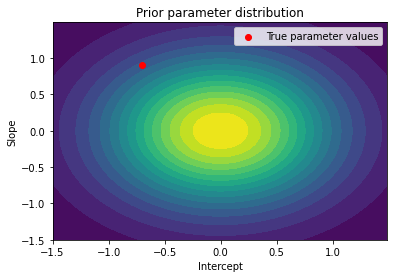

In [6]:
# Initialize BLR model
prior_mean = np.array([0, 0])
prior_cov = 1/2 * np.identity(2)
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

def plot_param_posterior(lower_bound, upper_bound, blr, title):
    fig = plt.figure()
    mesh_features, mesh_labels = np.mgrid[lower_bound:upper_bound:.01, lower_bound:upper_bound:.01]
    pos = np.dstack((mesh_features, mesh_labels))
    plt.contourf(mesh_features, mesh_labels, blr.param_posterior.pdf(pos), levels=15)
    plt.scatter(intercept, slope, color='red', label="True parameter values")
    plt.title(title)
    plt.xlabel("Intercept")
    plt.ylabel("Slope")
    plt.legend();
    
# Visualize parameter prior distribution
plot_param_posterior(lower_bound, upper_bound, blr, title="Prior parameter distribution")

features: (1,)
targets: (1,)
targets: (1, 1)
design_matrix: (1, 2)
post_cov: (2, 2)
noise_precision: 4.0
design_matrix: (1, 2)
targets: (1, 1)
prior_mean: (2, 1)
post_cov: (2, 2)
post_mean: (2, 1)
post_mean.flatten(): [-0.57861569  0.21777917]
post_cov: (2, 2)

features: (4,)
targets: (4,)
targets: (4, 1)
design_matrix: (4, 2)
post_cov: (2, 2)
noise_precision: 4.0
design_matrix: (4, 2)
targets: (4, 1)
prior_mean: (2, 1)
post_cov: (2, 2)
post_mean: (2, 1)
post_mean.flatten(): [-0.47195653  0.46668207]
post_cov: (2, 2)

features: (5,)
targets: (5,)
targets: (5, 1)
design_matrix: (5, 2)
post_cov: (2, 2)
noise_precision: 4.0
design_matrix: (5, 2)
targets: (5, 1)
prior_mean: (2, 1)
post_cov: (2, 2)
post_mean: (2, 1)
post_mean.flatten(): [-0.59964116  0.53999463]
post_cov: (2, 2)

features: (40,)
targets: (40,)
targets: (40, 1)
design_matrix: (40, 2)
post_cov: (2, 2)
noise_precision: 4.0
design_matrix: (40, 2)
targets: (40, 1)
prior_mean: (2, 1)
post_cov: (2, 2)
post_mean: (2, 1)
post_mean.f

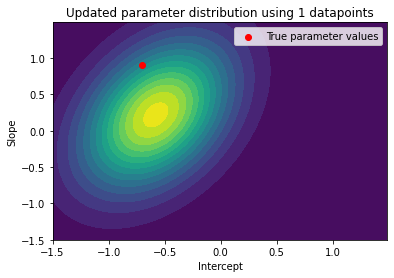

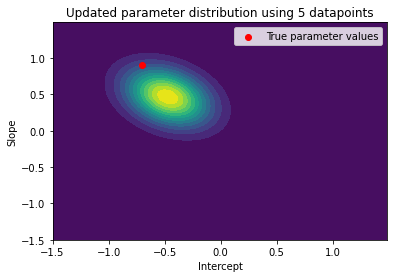

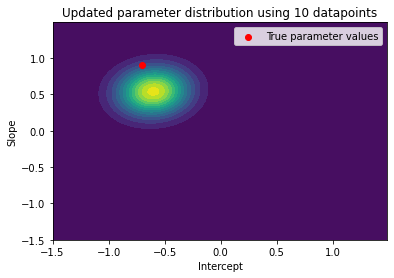

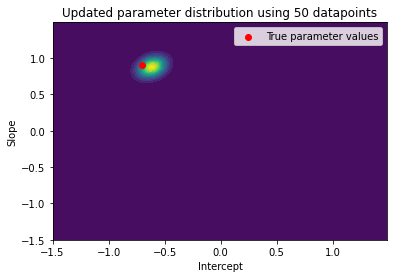

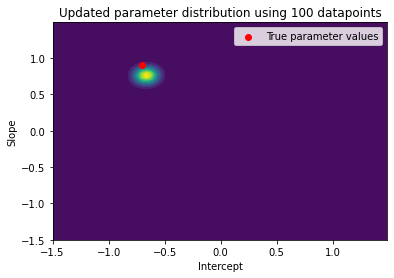

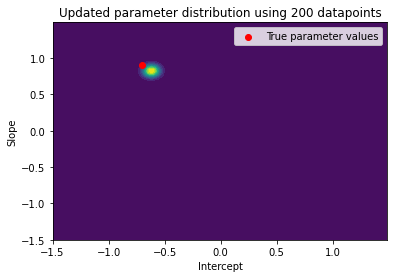

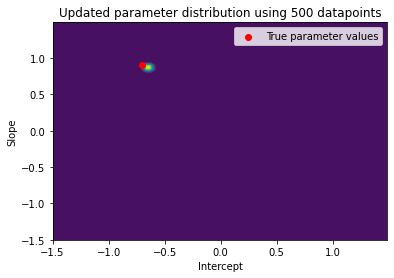

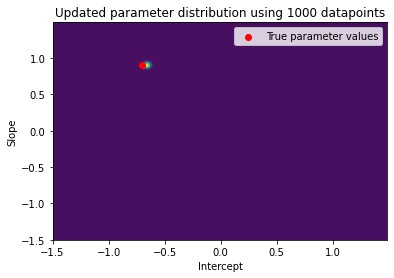

In [7]:
n_points_lst = [1, 5, 10, 50, 100, 200, 500, 1000]
previous_n_points = 0
for n_points in n_points_lst:
    train_features = features[previous_n_points:n_points]
    train_labels = noise_corrupted_labels[previous_n_points:n_points]
    blr.update_posterior(train_features, train_labels)
    
    # Visualize updated parameter posterior distribution
    plot_param_posterior(lower_bound, 
                         upper_bound, 
                         blr, 
                         title=f"Updated parameter distribution using {n_points} datapoints")
    
    previous_n_points = n_points
    print()

In [9]:
# Generate dataset
features = np.random.uniform(lower_bound, upper_bound, n_datapoints)
labels = compute_function_labels(slope, intercept, 0., features)
noise_corrupted_labels = compute_function_labels(slope, intercept, noise_std_dev, features)

prior_mean = np.array([0, 0])[:,None]

previous_n_points = 10
n_points = 100
train_features = features[previous_n_points:n_points]
train_labels = noise_corrupted_labels[previous_n_points:n_points]
targets = train_labels
features = train_features 
targets = targets[:, np.newaxis]
noise_precision = 1 / noise_var

print('targets:', targets.shape)

# compute_design_matrix
n_samples = len(features)
phi_0 = np.ones(n_samples)
design_matrix = np.stack((phi_0, features), axis=1)
print('design_matrix:', design_matrix.shape)

# Update the covariance matrix, shape (2, 2)
design_matrix_dot_product = design_matrix.T.dot(design_matrix)
inv_prior_cov = np.linalg.inv(prior_cov)
post_cov = np.linalg.inv(inv_prior_cov +  noise_precision * design_matrix_dot_product)
print('post_cov:', post_cov.shape)

# Update the mean, shape (2, 1)
print('noise_precision:', noise_precision)
print('design_matrix:', design_matrix.shape)
print('targets:', targets.shape)
print('prior_mean:', prior_mean.shape)
print('post_cov:', post_cov.shape)

post_mean = post_cov.dot(  inv_prior_cov.dot(prior_mean) + noise_precision * design_matrix.T.dot(targets))
print('post_mean:', post_mean.shape)

print('post_mean.flatten():', post_mean.flatten())
print('post_cov:', post_cov.shape)

# Update the posterior distribution
param_posterior = multivariate_normal(post_mean.flatten(), post_cov)

targets: (90, 1)
design_matrix: (90, 2)
post_cov: (2, 2)
noise_precision: 4.0
design_matrix: (90, 2)
targets: (90, 1)
prior_mean: (2, 1)
post_cov: (2, 2)
post_mean: (2, 1)
post_mean.flatten(): [-0.70639278  0.858976  ]
post_cov: (2, 2)
